In [1]:
!pip install --user pydicom pillow matplotlib easyocr


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Bbox: [[np.float64(553.0105172330341), np.float64(390.2757240778452)], [np.float64(931.3251971703547), np.float64(273.37740176743523)], [np.float64(984.9894827669659), np.float64(519.7242759221548)], [np.float64(606.6748028296453), np.float64(636.6225982325648)]]
 text: Lcc
 conf: 0.9988458853712683



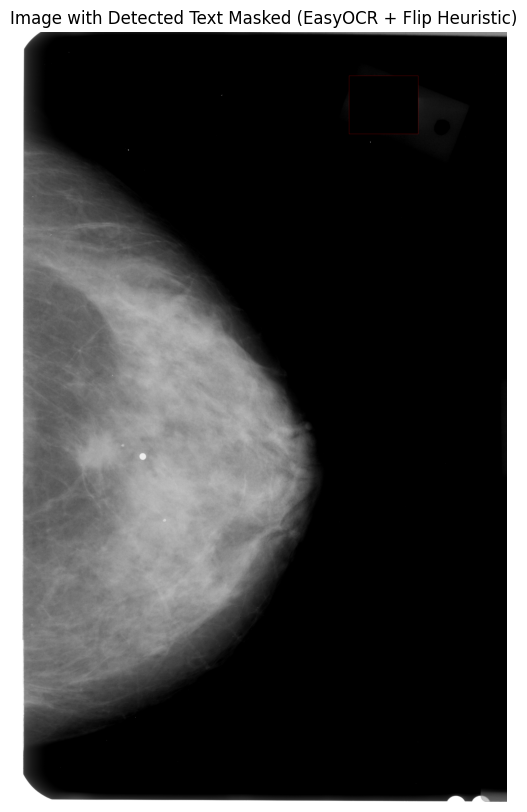

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import pydicom
import easyocr

# === FUNCTION TO LOAD DICOM AS PIL IMAGE ===
def load_dicom_image(image_path: str) -> Image.Image:
    ds = pydicom.dcmread(image_path)
    image_array = ds.pixel_array.astype(np.float32)

    # Normalize to [0, 255]
    image_array -= image_array.min()
    image_array /= (image_array.max() + 1e-5)
    image_array *= 255.0
    image_array = image_array.clip(0, 255).astype(np.uint8)

    pil_img = Image.fromarray(image_array).convert("RGB")
    return pil_img

# === TRY OCR WITH FLIPPING AND RETURN BEST RESULT ===
def best_ocr_results(image: Image.Image, reader, conf_threshold: float = 0.5):
    np_img = np.array(image)
    np_img_flipped = np.array(image.transpose(Image.FLIP_LEFT_RIGHT))

    results_original = reader.readtext(np_img)
    results_flipped = reader.readtext(np_img_flipped)

    score_orig = sum(conf for _, _, conf in results_original if conf > conf_threshold)
    score_flip = sum(conf for _, _, conf in results_flipped if conf > conf_threshold)

    if score_flip > score_orig:
        return results_flipped, True  # flipped is better
    else:
        return results_original, False  # original is better

# === MASK TEXT WITH EASYOCR + FLIP HEURISTIC ===
def mask_text_with_easyocr(image: Image.Image, fill=(0, 255, 255), draw_outline=True) -> Image.Image:
    reader = easyocr.Reader(['en'], gpu=True)
    results, is_flipped = best_ocr_results(image, reader)

    if is_flipped:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)

    draw = ImageDraw.Draw(image)
    for (bbox, text, conf) in results:
        print(f"Bbox: {bbox}\n text: {text}\n conf: {conf}\n")
        if conf < 0.5:
            continue
        pts = [tuple(map(int, point)) for point in bbox]
        x_coords, y_coords = zip(*pts)
        x_min, x_max = min(x_coords), max(x_coords)
        y_min, y_max = min(y_coords), max(y_coords)

        draw.rectangle([(x_min, y_min), (x_max, y_max)], fill=fill)
        if draw_outline:
            draw.rectangle([(x_min, y_min), (x_max, y_max)], outline="red", width=1)

    if is_flipped:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)

    return image

# === DICOM FILE PATH ===
image_path = r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Mass-Training_P_00001_LEFT_CC\1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994\1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515\1-1.dcm"

# === LOAD AND MASK IMAGE ===
image = load_dicom_image(image_path)
masked_image = mask_text_with_easyocr(image.copy(), fill=(0, 0, 0), draw_outline=True)

# === DISPLAY RESULT ===
plt.figure(figsize=(10, 10))
plt.imshow(masked_image)
plt.axis("off")
plt.title("Image with Detected Text Masked (EasyOCR + Flip Heuristic)")
plt.show()
